# IMBD reviews model selection

In [1]:
# Dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import numpy as np
import tensorflow as tf
import nltk
from collections import Counter
import string
import itertools
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow_text as text
import tensorflow_hub as hub
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalMaxPool1D, BatchNormalization, Dense, RNN, GRU, LSTM, TimeDistributed, Bidirectional, Activation, Embedding, Input, Conv1D, Dropout
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax


plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data preprocessing

In [2]:
# Data imports
with open('reviews.txt', 'r') as f:
  reviews = f.read()
with open('labels.txt', 'r') as f:
  labels = f.read()
  
# Remove punctuation
reviews = "".join([char for char in reviews if char not in string.punctuation])

reviews = reviews.split('\n')
labels = labels.split('\n')

# Tokenization, Lemmatization, Stemming, Stopwords. Label numerical encoding
reviews_tokenized = []
reviews_tokenized_joined = []
for review in reviews:
  splitted_review = nltk.word_tokenize(review)
  splitted_review = [word for word in splitted_review if word not in stop_words]
  splitted_review = [WordNetLemmatizer().lemmatize(w) for w in splitted_review]
  splitted_review = [PorterStemmer().stem(w).strip() for w in splitted_review]
  reviews_tokenized.append(splitted_review)
  joined_review = ' '.join(splitted_review)
  reviews_tokenized_joined.append(joined_review)
  
# Remove empty reviews and the corresponding labels
empty_idx = []
for i, review in enumerate(reviews_tokenized):
  if len(review) == 0:
    empty_idx.append(i)
    
for i in empty_idx:
  reviews_tokenized.pop(i)
  reviews_tokenized_joined.pop(i)
  reviews.pop(i)
  labels.pop(i)
  
reviews_unrolled = list(itertools.chain(*reviews_tokenized))
labels = [1 if label == "positive" else 0 for label in labels]

### Part 1. Multinomial Naive Bayes with Count Vectorizer

In [3]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size = 0.2, random_state = 1)

MultinomialNB_CountVectorizer_start_time = time.time()

# Count vectorizer feature transformation
count_vector = CountVectorizer(stop_words = 'english', binary = False)

training_data = count_vector.fit_transform(X_train)
test_data = count_vector.transform(X_test)

# Multinomial Naive Bayes model predictions
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB_CountVectorizer_predictions = naive_bayes.predict(test_data)

MultinomialNB_CountVectorizer_end_time = time.time()
MultinomialNB_CountVectorizer_execution_time = MultinomialNB_CountVectorizer_end_time - MultinomialNB_CountVectorizer_start_time

# Model evaluation
print('MultinomialNB CountVectorizer Training time: {} seconds'. format(round(MultinomialNB_CountVectorizer_execution_time, 2)))
print('MultinomialNB CountVectorizer Accuracy score: ', format(accuracy_score(y_test, MultinomialNB_CountVectorizer_predictions)))
print('MultinomialNB CountVectorizer Precision score: ', format(precision_score(y_test, MultinomialNB_CountVectorizer_predictions)))
print('MultinomialNB CountVectorizer Recall score: ', format(recall_score(y_test, MultinomialNB_CountVectorizer_predictions)))
print('MultinomialNB CountVectorizer F1 score: ', format(f1_score(y_test, MultinomialNB_CountVectorizer_predictions)))

# Model evaluation dictionary
MultinomialNB_CountVectorizer_results = {'Name': "MultinomialNB CountVectorizer", 
                                         "Training Time": round(MultinomialNB_CountVectorizer_execution_time, 2),
                                         "Accuracy score": accuracy_score(y_test, MultinomialNB_CountVectorizer_predictions),
                                         "Precision score": precision_score(y_test, MultinomialNB_CountVectorizer_predictions),
                                         "Recall score": recall_score(y_test, MultinomialNB_CountVectorizer_predictions),
                                         "F1 score": f1_score(y_test, MultinomialNB_CountVectorizer_predictions)}

MultinomialNB CountVectorizer Training time: 2.18 seconds
MultinomialNB CountVectorizer Accuracy score:  0.8582
MultinomialNB CountVectorizer Precision score:  0.8621118012422361
MultinomialNB CountVectorizer Recall score:  0.8470301057770545
MultinomialNB CountVectorizer F1 score:  0.8545044120664889


### Part 2. Multinomial Naive Bayes with TF-IDF

In [4]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size = 0.2, random_state = 1)

MultinomialNB_tfidf_start_time = time.time()

# TF-IDF feature transformation
tfidf = TfidfVectorizer(stop_words = 'english', binary = False)

training_data = tfidf.fit_transform(X_train)
test_data = tfidf.transform(X_test)

# Multinomial Naive Bayes model predictions
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB_tfidf_predictions = naive_bayes.predict(test_data)

MultinomialNB_tfidf_end_time = time.time()
MultinomialNB_tfidf_execution_time = MultinomialNB_tfidf_end_time - MultinomialNB_tfidf_start_time

# Model evaluation
print('MultinomialNB tfidf Training time: {} seconds'. format(round(MultinomialNB_tfidf_execution_time, 2)))
print('MultinomialNB tfidf Accuracy score: ', format(accuracy_score(y_test, MultinomialNB_tfidf_predictions)))
print('MultinomialNB tfidf Precision score: ', format(precision_score(y_test, MultinomialNB_tfidf_predictions)))
print('MultinomialNB tfidf Recall score: ', format(recall_score(y_test, MultinomialNB_tfidf_predictions)))
print('MultinomialNB tfidf F1 score: ', format(f1_score(y_test, MultinomialNB_tfidf_predictions)))

# Model evaluation dictionary
MultinomialNB_tfidf_results = {'Name': "MultinomialNB tfidf", 
                                         "Training Time": round(MultinomialNB_tfidf_execution_time, 2),
                                         "Accuracy score": accuracy_score(y_test, MultinomialNB_tfidf_predictions),
                                         "Precision score": precision_score(y_test, MultinomialNB_tfidf_predictions),
                                         "Recall score": recall_score(y_test, MultinomialNB_tfidf_predictions),
                                         "F1 score": f1_score(y_test, MultinomialNB_tfidf_predictions)}

MultinomialNB tfidf Training time: 2.18 seconds
MultinomialNB tfidf Accuracy score:  0.864
MultinomialNB tfidf Precision score:  0.8587570621468926
MultinomialNB tfidf Recall score:  0.8657445077298617
MultinomialNB tfidf F1 score:  0.8622366288492707


### Part 3. Vaders sentiment classifier

#### Extra preprocessing step

In [5]:
# Create dataframe for convenience

df = pd.DataFrame({'Text': reviews, 'Label': labels})
df = df.reset_index()
df['Id'] = df['index'] + 1
df.drop('index', axis = 1, inplace = True)
df = df[['Id', 'Text', 'Label']]
df.head()

,Id,Text,Label
0,1,bromwell high is a cartoon comedy it ran at t...,1
1,2,story of a man who has unnatural feelings for ...,0
2,3,homelessness or houselessness as george carli...,1
3,4,airport starts as a brand new luxury pla...,0
4,5,brilliant over acting by lesley ann warren b...,1


In [6]:
vader_start_time = time.time()

# Define Vader Sentiment analyzer model
sia = SentimentIntensityAnalyzer()

# Get the results
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
  text = row['Text']
  myid = row['Id']
  res[myid] = sia.polarity_scores(text)
  
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index': 'Id'})
vaders = vaders.merge(df, how = 'left')
vaders['Predicted_Label'] = np.where(vaders['compound'] >= 0, 1, 0)

vader_end_time = time.time()
vader_execution_time = vader_end_time - vader_start_time

vaders.head()

  0%|          | 0/25000 [00:00<?, ?it/s]

,Id,neg,neu,pos,compound,Text,Label,Predicted_Label
0,1,0.044,0.916,0.041,-0.1027,bromwell high is a cartoon comedy it ran at t...,1,0
1,2,0.108,0.746,0.146,0.7003,story of a man who has unnatural feelings for ...,0,1
2,3,0.120,0.733,0.147,0.9311,homelessness or houselessness as george carli...,1,1
3,4,0.161,0.692,0.147,-0.9180,airport starts as a brand new luxury pla...,0,0
4,5,0.077,0.738,0.185,0.9657,brilliant over acting by lesley ann warren b...,1,1


In [7]:
# Model evaluation
print('Vader Training time: {} seconds'. format(round(vader_execution_time, 2)))
print('Vader Accuracy score: ', format(accuracy_score(vaders['Label'], vaders['Predicted_Label'])))
print('Vader Precision score: ', format(precision_score(vaders['Label'], vaders['Predicted_Label'])))
print('Vader Recall score: ', format(recall_score(vaders['Label'], vaders['Predicted_Label'])))
print('Vader F1 score: ', format(f1_score(vaders['Label'], vaders['Predicted_Label'])))

# Model evaluation dictionary
vader_results = {'Name': "Vaders Analyser", 
                                         "Training Time": round(vader_execution_time, 2),
                                         "Accuracy score": accuracy_score(vaders['Label'], vaders['Predicted_Label']),
                                         "Precision score": precision_score(vaders['Label'], vaders['Predicted_Label']),
                                         "Recall score": recall_score(vaders['Label'], vaders['Predicted_Label']),
                                         "F1 score": f1_score(vaders['Label'], vaders['Predicted_Label'])}

Vader Training time: 34.77 seconds
Vader Accuracy score:  0.69088
Vader Precision score:  0.6435101648021172
Vader Recall score:  0.85592
Vader F1 score:  0.7346700542470646


### Part 4. RNN manual implementation

In [8]:
# Create vocabulary, word2index reference and convert the reviews into numerical form
vocab_size = 10000

word_counter = Counter(reviews_unrolled)
word_counter = dict(word_counter.most_common(vocab_size))
word2index = {k:i for i,k in enumerate(word_counter.keys(), start = 3)}

# Convert reveies to integers
reviews_int = []
for review in reviews_tokenized:
  cur_review = [1]
  for word in review:
    if word in word2index.keys():
      cur_review.append(word2index[word])
    else:
      cur_review.append(2)
  reviews_int.append(cur_review)
  
# Pad sequences
padded_reviews = pad_sequences(reviews_int, maxlen = 500, padding = 'pre', truncating = 'pre')

# Train test split on padded sequences
X_train, X_test, y_train, y_test = train_test_split(padded_reviews, labels, test_size = 0.2, random_state = 1)

X_train = np.array(X_train).reshape(20000, 500)
X_test = np.array(X_test).reshape(5000, 500)

y_train = np.array(y_train).reshape(20000, 1)
y_test = np.array(y_test).reshape(5000, 1)

In [9]:
# Define the model
dropout_rate = 0.5

# Model checkpoint callback
checkpoint = ModelCheckpoint(filepath='best_RNN_manual_model.h5', 
                             monitor='val_loss', 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1, 
                           restore_best_weights=True)

inputs = Input(shape = (X_train.shape[1:]))
mask = tf.keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
x = Embedding(input_dim = vocab_size, output_dim = 128, input_length = 200)(inputs)
x = Conv1D(filters = 200, kernel_size = 13, strides = 1, padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = GRU(128, return_sequences = True)(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = GRU(128, return_sequences = False)(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = inputs, outputs = outputs)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 500, 200)          333000    
                                                                 
 batch_normalization (BatchN  (None, 500, 200)         800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 500, 200)          0         
                                                                 
 gru (GRU)                   (None, 500, 128)          126720    
                                                             

In [10]:
# Train the model

Manual_RNN_start_time = time.time()

history = model.fit(X_train, y_train, epochs = 10, batch_size = 128, validation_data = (X_test, y_test), callbacks = [checkpoint, early_stop])

Manual_RNN_end_time = time.time()
Manual_RNN_execution_time = Manual_RNN_end_time - Manual_RNN_start_time

Epoch 1/10
157/157 [==============================] - 23s 121ms/step - loss: 0.6635 - accuracy: 0.6097 - val_loss: 0.4373 - val_accuracy: 0.8134
Epoch 2/10
157/157 [==============================] - 19s 119ms/step - loss: 0.2871 - accuracy: 0.8857 - val_loss: 0.7137 - val_accuracy: 0.6270
Epoch 3/10
157/157 [==============================] - 19s 120ms/step - loss: 0.1844 - accuracy: 0.9320 - val_loss: 0.4659 - val_accuracy: 0.7838
Epoch 4/10
157/157 [==============================] - 19s 119ms/step - loss: 0.1304 - accuracy: 0.9523 - val_loss: 0.6486 - val_accuracy: 0.7996
Epoch 4: early stopping


In [11]:
# Model predictions
Manual_RNN_predictions = model.predict(X_test)

Manual_RNN_predictions_results = []
for i in Manual_RNN_predictions:
  if i[0] >= 0.5:
    Manual_RNN_predictions_results.append(1)
  else:
    Manual_RNN_predictions_results.append(0)

# Model evaluation
print('Manual RNN Training time: {} seconds'. format(round(Manual_RNN_execution_time, 2)))
print('Manual RNN Accuracy score: ', format(accuracy_score(y_test, Manual_RNN_predictions_results)))
print('Manual RNN Precision score: ', format(precision_score(y_test, Manual_RNN_predictions_results)))
print('Manual RNN Recall score: ', format(recall_score(y_test, Manual_RNN_predictions_results)))
print('Manual RNN F1 score: ', format(f1_score(y_test, Manual_RNN_predictions_results)))

# Model evaluation dictionary
Manual_RNN_results = {'Name': "Manual RNN", 
                 "Training Time": round(Manual_RNN_execution_time, 2),
                 "Accuracy score": accuracy_score(y_test, Manual_RNN_predictions_results),
                 "Precision score": precision_score(y_test, Manual_RNN_predictions_results),
                 "Recall score": recall_score(y_test, Manual_RNN_predictions_results),
                 "F1 score": f1_score(y_test, Manual_RNN_predictions_results)}

157/157 [==============================] - 3s 18ms/step
Manual RNN Training time: 79.27 seconds
Manual RNN Accuracy score:  0.8134
Manual RNN Precision score:  0.8399465002229157
Manual RNN Recall score:  0.7664768104149715
Manual RNN F1 score:  0.801531589023612


### Part 5. Universal Sentence encoder transfer learning

In [12]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size = 0.2, random_state = 1)

X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train).reshape(20000, 1)
y_test = np.array(y_test).reshape(5000, 1)

In [13]:
# Download the Universal Sentence encoder layer for transfer learning
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                         input_shape = [],
                                         dtype=tf.string,
                                         trainable = False)

# Model checkpoint callback
checkpoint = ModelCheckpoint(filepath='best_sentence_encoder_model.h5', 
                             monitor='val_loss', 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1, 
                           restore_best_weights=True)

# Define the model
model = Sequential([
  sentence_encoder_layer,
  Dense(1024, activation = 'relu'),
  Dense(1024, activation = 'relu'),
  Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 258,373,761
Trainable params: 1,575,937
Non-trainable params: 256,797,824
_________________________________________________________________


In [14]:
# Train the model

Sentence_encoder_start_time = time.time()

history = model.fit(X_train, y_train, epochs = 10, batch_size = 128, validation_data = (X_test, y_test), callbacks = [checkpoint, early_stop])

Sentence_encoder_end_time = time.time()
Sentence_encoder_execution_time = Sentence_encoder_end_time - Sentence_encoder_start_time

Epoch 1/10
157/157 [==============================] - 23s 137ms/step - loss: 0.3665 - accuracy: 0.8396 - val_loss: 0.3343 - val_accuracy: 0.8618
Epoch 2/10
157/157 [==============================] - 20s 130ms/step - loss: 0.3145 - accuracy: 0.8680 - val_loss: 0.3088 - val_accuracy: 0.8672
Epoch 3/10
157/157 [==============================] - 18s 116ms/step - loss: 0.2893 - accuracy: 0.8803 - val_loss: 0.3131 - val_accuracy: 0.8658
Epoch 4/10
157/157 [==============================] - 18s 117ms/step - loss: 0.2565 - accuracy: 0.8976 - val_loss: 0.3215 - val_accuracy: 0.8588
Epoch 5/10
157/157 [==============================] - 19s 119ms/step - loss: 0.2108 - accuracy: 0.9204 - val_loss: 0.3473 - val_accuracy: 0.8580
Epoch 5: early stopping


In [15]:
# Model predictions
Sentence_encoder_predictions = model.predict(X_test)

Sentence_encoder_predictions_results = []
for i in Sentence_encoder_predictions:
  if i[0] >= 0.5:
    Sentence_encoder_predictions_results.append(1)
  else:
    Sentence_encoder_predictions_results.append(0)
    
# Model evaluation
print('Sentence encoder Training time: {} seconds'. format(round(Sentence_encoder_execution_time, 2)))
print('Sentence encoder Accuracy score: ', format(accuracy_score(y_test, Sentence_encoder_predictions_results)))
print('Sentence encoder Precision score: ', format(precision_score(y_test, Sentence_encoder_predictions_results)))
print('Sentence encoder Recall score: ', format(recall_score(y_test, Sentence_encoder_predictions_results)))
print('Sentence encoder F1 score: ', format(f1_score(y_test, Sentence_encoder_predictions_results)))

# Model evaluation dictionary
Sentence_encoder_results = {'Name': "Sentence encoder", 
                 "Training Time": round(Sentence_encoder_execution_time, 2),
                 "Accuracy score": accuracy_score(y_test, Sentence_encoder_predictions_results),
                 "Precision score": precision_score(y_test, Sentence_encoder_predictions_results),
                 "Recall score": recall_score(y_test, Sentence_encoder_predictions_results),
                 "F1 score": f1_score(y_test, Sentence_encoder_predictions_results)}

157/157 [==============================] - 4s 24ms/step
Sentence encoder Training time: 99.0 seconds
Sentence encoder Accuracy score:  0.8672
Sentence encoder Precision score:  0.8734388009991674
Sentence encoder Recall score:  0.853539462978031
Sentence encoder F1 score:  0.8633744855967078


### Part 6. Roberta Huggingface model

In [16]:
# Download the pretrained model
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [17]:
# Auxillary polarity scores function
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors = 'tf')
  output = model(**encoded_text)
  scores = output[0][0].numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
  }
  return scores_dict

In [18]:
# Predict results with each of the rows in the dataframe

Roberta_start_time = time.time()

res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    vader_result = sia.polarity_scores(text)

    vader_result_rename = {}
    for key, value in vader_result.items():
      vader_result_rename[f'vader_{key}'] = value

    roberta_result = polarity_scores_roberta(text)
    both_results = {**vader_result_rename, **roberta_result}
    res[myid] = both_results
    
Roberta_end_time = time.time()
Roberta_execution_time = Roberta_end_time - Roberta_start_time

  0%|          | 0/25000 [00:00<?, ?it/s]

In [19]:
# Save roberta model results
roberta_results = []
for i in range(1, len(df) + 1):
  roberta_results.append(int(res[i]['roberta_pos'] > res[i]['roberta_neg']))
  
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index': 'Id'})
results_df = results_df.merge(vaders, how = 'left')
results_df.drop(['neg', 'neu', 'pos', 'compound'], axis = 1, inplace = True)

results_df['Roberta_Predictions'] = results_df['roberta_pos'] > results_df['roberta_neg']
results_df['Roberta_Predictions'] = results_df['Roberta_Predictions'].astype(int)
results_df.head(3)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Text,Label,Predicted_Label,Roberta_Predictions
0,1,0.044,0.916,0.041,-0.1027,0.676774,0.275353,0.047873,bromwell high is a cartoon comedy it ran at t...,1,0,0
1,2,0.108,0.746,0.146,0.7003,0.397576,0.361840,0.240584,story of a man who has unnatural feelings for ...,0,1,0
2,3,0.120,0.733,0.147,0.9311,0.450941,0.481239,0.067820,homelessness or houselessness as george carli...,1,1,0


In [26]:
# Model evaluation
print('Roberta Training time: {} seconds'. format(round(Roberta_execution_time, 2)))
print('Roberta Accuracy score: ', format(accuracy_score(results_df['Label'], results_df['Roberta_Predictions'])))
print('Roberta Precision score: ', format(precision_score(results_df['Label'], results_df['Roberta_Predictions'])))
print('Roberta Recall score: ', format(recall_score(results_df['Label'], results_df['Roberta_Predictions'])))
print('Roberta F1 score: ', format(f1_score(results_df['Label'], results_df['Roberta_Predictions'])))

# Model evaluation dictionary
Roberta_results = {'Name': "Roberta", 
                 "Training Time": round(Roberta_execution_time, 2),
                 "Accuracy score": accuracy_score(results_df['Label'], results_df['Roberta_Predictions']),
                 "Precision score": precision_score(results_df['Label'], results_df['Roberta_Predictions']),
                 "Recall score": recall_score(results_df['Label'], results_df['Roberta_Predictions']),
                 "F1 score": f1_score(results_df['Label'], results_df['Roberta_Predictions'])}

Roberta Training time: 3136.88 seconds
Roberta Accuracy score:  0.85132
Roberta Precision score:  0.8653798152924537
Roberta Recall score:  0.83208
Roberta F1 score:  0.8484032790896855


### All models summary

In [27]:
# Create a DataFrame with a summary for all models and KPIs
results_dict_list = [MultinomialNB_CountVectorizer_results,
                     MultinomialNB_tfidf_results,
                     vader_results,
                     Manual_RNN_results,
                     Sentence_encoder_results,
                     Roberta_results
                     ]

df = pd.DataFrame(results_dict_list)
df

,Name,Training Time,Accuracy score,Precision score,Recall score,F1 score
0,MultinomialNB CountVectorizer,2.18,0.85820,0.862112,0.847030,0.854504
1,MultinomialNB tfidf,2.18,0.86400,0.858757,0.865745,0.862237
2,Vaders Analyser,34.77,0.69088,0.643510,0.855920,0.734670
3,Manual RNN,79.27,0.81340,0.839947,0.766477,0.801532
4,Sentence encoder,99.00,0.86720,0.873439,0.853539,0.863374
5,Roberta,3136.88,0.85132,0.865380,0.832080,0.848403


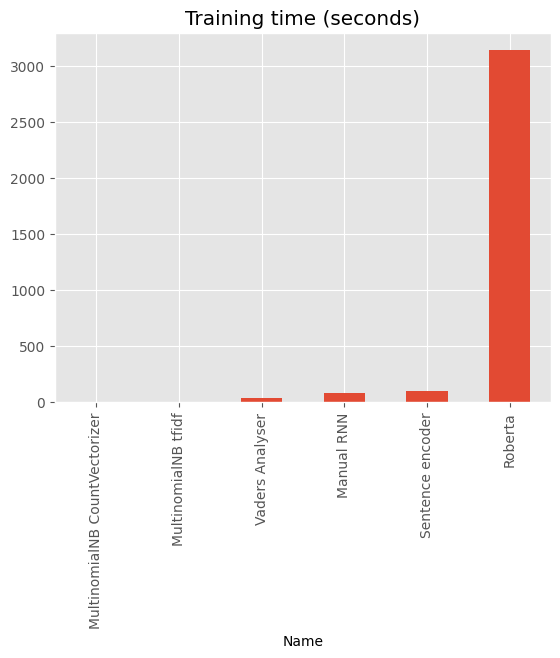

In [57]:
# Training time
df.plot(kind='bar', x='Name', y='Training Time')
plt.title("Training time (seconds)")
plt.legend().remove()

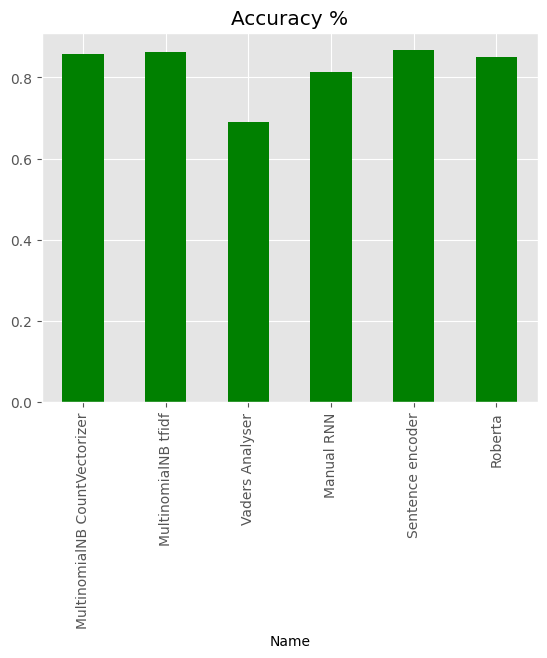

In [58]:
# Accuracy
df.plot(kind='bar', x='Name', y='Accuracy score', color = 'green')
plt.title("Accuracy %")
plt.legend().remove()

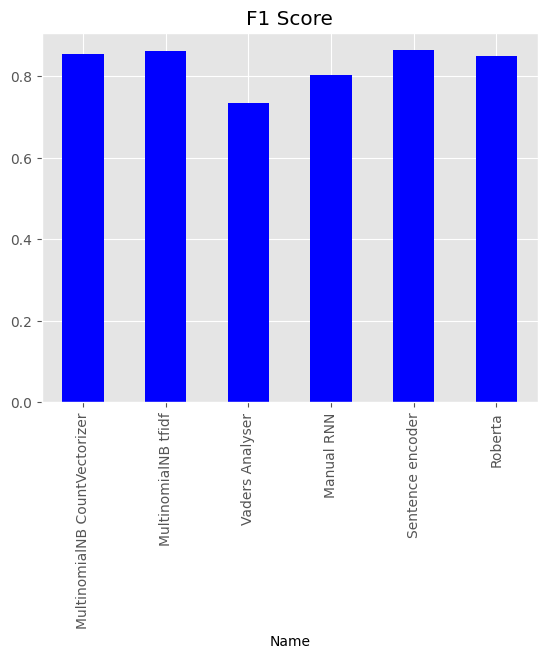

In [59]:
# F1 Scores
df.plot(kind='bar', x='Name', y='F1 score', color = 'blue')
plt.title("F1 Score")
plt.legend().remove()